# Streaming History EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


hist_df = pd.read_csv('data/stream_hist_20_31_01__11_40_28.csv')

In [2]:
hist_df['endTime'] = (pd.to_datetime(hist_df['endTime'])
                        .dt.tz_localize('UTC')
                        .dt.tz_convert('US/Eastern'))

hist_df['artistName'] = pd.Categorical(hist_df['artistName'])
hist_df['trackName'] = pd.Categorical(hist_df['trackName'])

In [3]:
min_date = hist_df['endTime'].dt.date.min()
max_date = hist_df['endTime'].dt.date.max()
print(f'Date range: {min_date} - {max_date}')

Date range: 2019-01-30 - 2020-01-30


## Most played artists

In [4]:
most_played = hist_df.groupby('artistName').agg({'msPlayed': [np.sum, np.size]})

cols = most_played.columns.to_flat_index()
cols = ['_'.join(c) for c in cols]
most_played.columns = cols

most_played = most_played.reset_index()
most_played.head()

,artistName,msPlayed_sum,msPlayed_size
0,$NOT,133668,2
1,$US VALENTINO,133141,1
2,$uicideBoy$,920427,7
3,*NSYNC,146724,1
4,*repeat repeat,187498,1


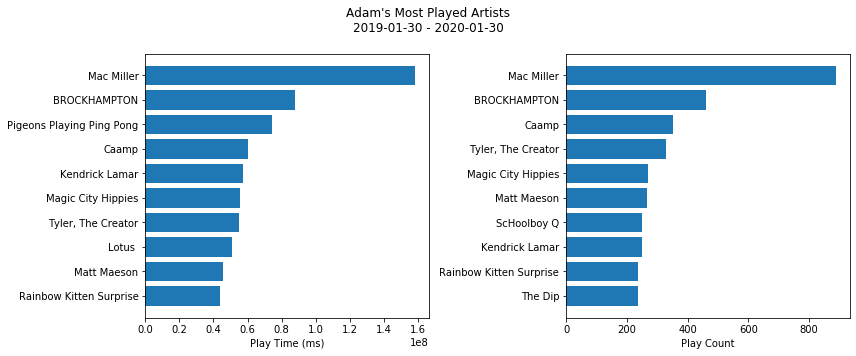

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

most_played = most_played.sort_values('msPlayed_sum', ascending=False)
plot_data = most_played.head(10).iloc[::-1, :]
axes[0].barh(plot_data['artistName'], plot_data['msPlayed_sum'])
axes[0].set_xlabel('Play Time (ms)')

most_played = most_played.sort_values('msPlayed_size', ascending=False)
plot_data = most_played.head(10).iloc[::-1, :]
axes[1].barh(plot_data['artistName'], plot_data['msPlayed_size'])
axes[1].set_xlabel('Play Count')

plt.suptitle(f'Adam\'s Most Played Artists\n{min_date} - {max_date}')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

## Most played songs

In [6]:
hist_df['track_artist'] = (hist_df['trackName'].astype(str) + ' (' + 
                           hist_df['artistName'].astype(str) + ')')

hist_df['track_artist'] = pd.Categorical(hist_df['track_artist'])

In [7]:
most_played = hist_df.groupby('track_artist').agg({'msPlayed': [np.sum, np.size]})

cols = most_played.columns.to_flat_index()
cols = ['_'.join(c) for c in cols]
most_played.columns = cols

most_played = most_played.reset_index()
most_played.head()

,track_artist,msPlayed_sum,msPlayed_size
0,"""99"" (Barns Courtney)",944566,5
1,#SuperNicer (Exmag),1626,1
2,#W W C (The Main Squeeze),955106,6
3,$Dreams (Max Frost),214080,1
4,&Run (Sir Sly),1132935,5


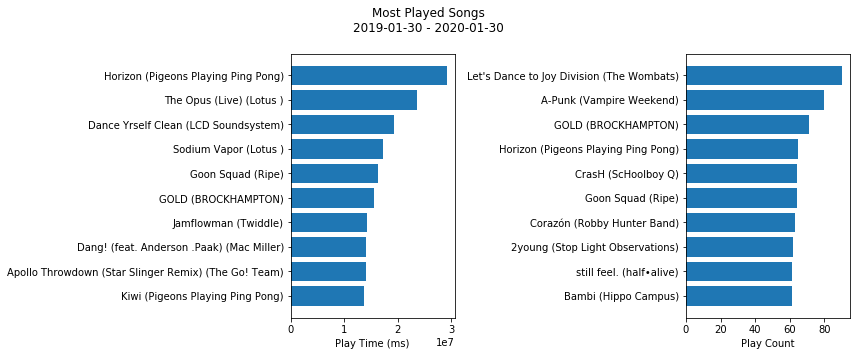

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

most_played = most_played.sort_values('msPlayed_sum', ascending=False)
plot_data = most_played.head(10).iloc[::-1, :]
axes[0].barh(plot_data['track_artist'], plot_data['msPlayed_sum'])
axes[0].set_xlabel('Play Time (ms)')

most_played = most_played.sort_values('msPlayed_size', ascending=False)
plot_data = most_played.head(10).iloc[::-1, :]
axes[1].barh(plot_data['track_artist'], plot_data['msPlayed_size'])
axes[1].set_xlabel('Play Count')

plt.suptitle(f'Most Played Songs\n{min_date} - {max_date}')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

## Plays by Time

In [9]:
half_min_ms = 30000
hist_df = hist_df.loc[hist_df['msPlayed'] > half_min_ms, :]

hist_df['date'] = hist_df['endTime'].dt.date
hist_df['day_of_week'] = hist_df['endTime'].dt.day_name()
hist_df['day_of_week_i'] = hist_df['endTime'].dt.weekday
hist_df['hour'] = hist_df['endTime'].dt.hour
hist_df.head()

,endTime,artistName,trackName,msPlayed,track_artist,date,day_of_week,day_of_week_i,hour
0,2019-11-01 19:46:00-04:00,Jon Bellion,Blu - Acoustic,48052,Blu - Acoustic (Jon Bellion),2019-11-01,Friday,4,19
1,2019-11-01 20:36:00-04:00,"Tyler, The Creator",IGOR'S THEME,200693,"IGOR'S THEME (Tyler, The Creator)",2019-11-01,Friday,4,20
2,2019-11-01 20:39:00-04:00,"Tyler, The Creator",EARFQUAKE,190066,"EARFQUAKE (Tyler, The Creator)",2019-11-01,Friday,4,20
3,2019-11-01 20:42:00-04:00,"Tyler, The Creator",I THINK,212013,"I THINK (Tyler, The Creator)",2019-11-01,Friday,4,20
5,2019-11-01 20:45:00-04:00,"Tyler, The Creator",RUNNING OUT OF TIME,177226,"RUNNING OUT OF TIME (Tyler, The Creator)",2019-11-01,Friday,4,20


In [10]:
plays_by_date = (hist_df
                  .sort_values('date')
                  .groupby('date')['msPlayed']
                  .agg(['size', 'sum'])
                  .reset_index())
plays_by_date['cumplaycount'] = plays_by_date['size'].cumsum()
plays_by_date['cumplaytime'] = plays_by_date['sum'].cumsum()

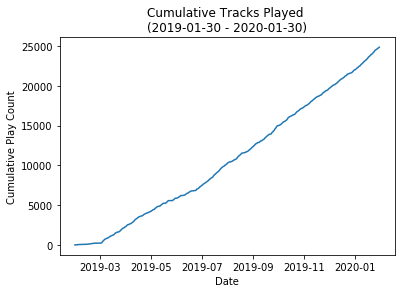

In [11]:
sns.lineplot('date', 'cumplaycount', data=plays_by_date)
plt.title(f'Cumulative Tracks Played \n({min_date} - {max_date})')
plt.xlabel('Date')
plt.ylabel('Cumulative Play Count')
plt.show()

In [12]:
plays_by_day = (hist_df
                 .groupby(['day_of_week', 'day_of_week_i'])['msPlayed']
                 .agg(['size', 'sum'])
                 .reset_index()
                 .sort_values('day_of_week_i'))

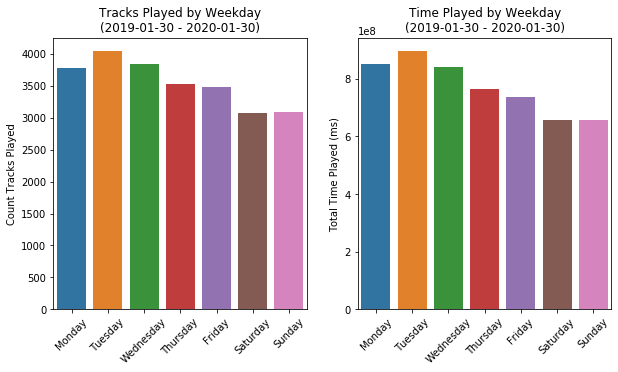

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot('day_of_week', 'size', data=plays_by_day, ax=axes[0])
axes[0].set_title(f'Tracks Played by Weekday\n({min_date} - {max_date})')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count Tracks Played')
axes[0].tick_params(labelrotation=45, axis='x')

sns.barplot('day_of_week', 'sum', data=plays_by_day)
axes[1].set_title(f'Time Played by Weekday\n({min_date} - {max_date})')
axes[1].set_xlabel('')
axes[1].set_ylabel('Total Time Played (ms)')
axes[1].tick_params(labelrotation=45, axis='x')
plt.show()

In [14]:
plays_by_hour = (hist_df
                  .groupby(['hour'])['msPlayed']
                  .agg(['size', 'sum'])
                  .reset_index()
                  .sort_values('hour'))

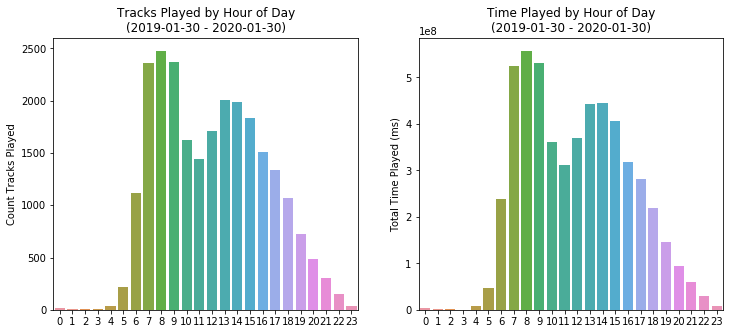

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot('hour', 'size', data=plays_by_hour, ax=axes[0])
axes[0].set_title(f'Tracks Played by Hour of Day\n({min_date} - {max_date})')
axes[0].set_xlabel('')
axes[0].set_ylabel('Count Tracks Played')

sns.barplot('hour', 'sum', data=plays_by_hour, ax=axes[1])
axes[1].set_title(f'Time Played by Hour of Day\n({min_date} - {max_date})')
axes[1].set_xlabel('')
axes[1].set_ylabel('Total Time Played (ms)')
plt.show()